# Spork experiments analysis

## Required libraries

* pandas==1.2.0
* scipy==1.6.0
* seaborn==0.11.0
* matplotlib==3.3.3
* numpy==1.19.5
* pingouin==0.3.12

## Installation

`pip install -r requirements.txt`

## Imports

In [1]:
import pathlib
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
import itertools
import math

## Directories set-up

In [2]:
sns.set(font_scale=3, palette="pastel", style="ticks", context="paper")

FILE_MERGE_EVALS = pd.read_csv("analysis/results/file_merge_evaluations.csv")

# merge directories in which JDime or Spork (or both) exhibit fails/conflicts
FAIL_MERGE_DIRS = set(FILE_MERGE_EVALS.query("outcome == 'fail' or outcome == 'timeout'").merge_dir.unique())
CONFLICT_MERGE_DIRS = set(
    FILE_MERGE_EVALS.query("outcome == 'conflict'").merge_dir.unique()
)

FILE_MERGE_EVALS.head()

,owner,repo,merge_commit,merge_dir,base_blob,left_blob,right_blob,expected_blob,replayed_blob,merge_cmd,outcome,line_diff_size,char_diff_size,char_diff_ratio,num_conflicts,conflict_size,num_syntax_errors,runtime
0,rackerlabs,atom-hopper,01be79d397cb824621eadcaded53b8bde7b6f657,rackerlabs/atom-hopper/01be79d397cb824621eadca...,4a25af165b3444ccdd28ab094399da128d2a7d98,19130f1069de3cd5868bafa03b44058af074513f,84ce7dcde1d0feefc0e8ea26164ffcb629d4a245,81eedf146f11bf224c2926a76b2b0cafc7cac4a9,53c81aed33ccdf40151ab165146689f7a8f8e7e0,jdime,success,210,651,0.949113,0,0,0,0.896167
1,rackerlabs,atom-hopper,01be79d397cb824621eadcaded53b8bde7b6f657,rackerlabs/atom-hopper/01be79d397cb824621eadca...,4a25af165b3444ccdd28ab094399da128d2a7d98,19130f1069de3cd5868bafa03b44058af074513f,84ce7dcde1d0feefc0e8ea26164ffcb629d4a245,81eedf146f11bf224c2926a76b2b0cafc7cac4a9,8d4341bb2ab36ee0e59e643c5584add0c2962ed8,automergeptm,success,212,771,0.939733,0,0,0,1.059407
2,rackerlabs,atom-hopper,01be79d397cb824621eadcaded53b8bde7b6f657,rackerlabs/atom-hopper/01be79d397cb824621eadca...,4a25af165b3444ccdd28ab094399da128d2a7d98,19130f1069de3cd5868bafa03b44058af074513f,84ce7dcde1d0feefc0e8ea26164ffcb629d4a245,81eedf146f11bf224c2926a76b2b0cafc7cac4a9,2fbbc3029f3d4be43eb1f90cfcdd4558559b7f77,spork,success,47,1206,0.909812,0,0,0,0.983729
3,rackerlabs,atom-hopper,0288e1abce0e7c51046007f7bd9061a3013056c5,rackerlabs/atom-hopper/0288e1abce0e7c51046007f...,310817a11fc12d80e16b0b73c123cfcb9e327747,15cac82ce3f5672300bb9a5c6a098f4273a2facd,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,82807e7519510a0383e45a59ecaa50db1d044400,jdime,success,472,3581,0.866981,0,0,0,0.703220
4,rackerlabs,atom-hopper,0288e1abce0e7c51046007f7bd9061a3013056c5,rackerlabs/atom-hopper/0288e1abce0e7c51046007f...,310817a11fc12d80e16b0b73c123cfcb9e327747,15cac82ce3f5672300bb9a5c6a098f4273a2facd,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,10c7c948e7be8c2a07b715a958d38da0ac1c97a0,automergeptm,success,474,3655,0.864232,0,0,0,0.751237


## Utility functions

In [3]:
def histogram(
    spork_values, jdime_values, automergeptm_values, bins, xlabel, ylabel="Frequency"
):
    smallest_value = min(0, min(itertools.chain(spork_values, jdime_values, automergeptm_values)))
    largest_value = max(itertools.chain(spork_values, jdime_values, automergeptm_values))

    has_lower_bound = smallest_value >= bins[0]
    has_upper_bound = largest_value < bins[-1]

    def get_ticklabel(bin_value):
        if bin_value == bins[0] and not has_lower_bound:
            return str(int(math.floor(smallest_value)))
        elif bin_value == bins[-1] and not has_upper_bound:
            return str(int(math.ceil(largest_value)))
        else:
            return str(bin_value)

    # limits values to be in the range of bins, but does not remove any values
    clipped_spork_values = np.clip(spork_values, bins[0], bins[-1])
    clipped_jdime_values = np.clip(jdime_values, bins[0], bins[-1])
    clipped_automergeptm_values = np.clip(automergeptm_values, bins[0], bins[-1])

    _, ax = plt.subplots()
    plt.hist(
        [clipped_spork_values, clipped_jdime_values, clipped_automergeptm_values],
        bins=bins,
    )
    set_hatches(ax)

    handles = [ax.patches[0], ax.patches[len(ax.patches) // 2], ax.patches[-1]]
    labels = ["Spork", "JDime", "AutoMergePTM"]
    plt.rcParams["figure.figsize"] = (20,3)
    plt.legend(handles, labels)
    plt.xticks(bins)
    plt.tick_params(axis="both", which="major", labelsize=20)

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    ticklabels = list(map(get_ticklabel, bins))
    ax.set_xticklabels(ticklabels)

    #print(spork_values.describe())
    #print(jdime_values.describe())
    #print(automergeptm_values.describe())

    spork_vs_jdime = pg.wilcoxon(spork_values, jdime_values, tail="two-sided")
    spork_vs_automergeptm = pg.wilcoxon(spork_values, automergeptm_values, tail="two-sided")
    reject, p_vals = pg.multicomp([spork_vs_jdime["p-val"], spork_vs_automergeptm["p-val"]])
    print("Spork vs JDime")
    print("P-value: " + str(p_vals[0]) + ", RBC: " + str(spork_vs_jdime["RBC"][0]))
    print("Spork vs AutoMergePTM")
    print("P-value: " + str(p_vals[1]) + ", RBC: " + str(spork_vs_automergeptm["RBC"][0]))

    return plt

def set_hatches(ax):
    for patch in ax.patches[len(ax.patches) // 3 :]:
        patch.set_hatch("/")
    for patch in ax.patches[int(2/3 * len(ax.patches)) :]:
        patch.set_hatch("x")

def get_aligned_results(
    merge_id_column: str,
    data_column: str,
    tool_column: str,
    frame: pd.DataFrame,
) -> pd.DataFrame:
    tools = frame[tool_column].unique()
    assert len(tools) > 0

    aligned_frame = frame[[merge_id_column]].drop_duplicates()
    for tool in tools:
        tool_frame = frame.query(f"{tool_column} == '{tool}'")[
            [merge_id_column, data_column]
        ].rename(columns={data_column: f"{tool}_{data_column}"})
        aligned_frame = aligned_frame.merge(tool_frame, on=merge_id_column)

    return aligned_frame

def get_aligned_mean_conflict_sizes():
    non_fail_conflict_dirs = CONFLICT_MERGE_DIRS - FAIL_MERGE_DIRS
    non_fail_conflict_merges = FILE_MERGE_EVALS[
        FILE_MERGE_EVALS.merge_dir.isin(non_fail_conflict_dirs)
    ]

    spork_conflicts = mean_conflict_sizes(non_fail_conflict_merges, "spork")
    jdime_conflicts = mean_conflict_sizes(non_fail_conflict_merges, "jdime")
    automergeptm_conflicts = mean_conflict_sizes(non_fail_conflict_merges, "automergeptm")

    return spork_conflicts.merge(jdime_conflicts, on="merge_dir").merge(automergeptm_conflicts, on="merge_dir")

def mean_conflict_sizes(frame: pd.DataFrame, tool: str):
    cmd_mean_conflict_sizes = frame[frame.merge_cmd == tool].merge_dir.to_frame()
    cmd_mean_conflict_sizes[f"{tool}_avg_size"] = frame[frame.merge_cmd == tool].apply(
        avg_chunk_size, axis=1
    )
    return cmd_mean_conflict_sizes

def avg_chunk_size(row):
    if row.num_conflicts:
        return row.conflict_size / row.num_conflicts
    return 0

## GitDiff size

Spork vs JDime
P-value: 1.850793713072793e-213, RBC: -0.9627080567752477
Spork vs AutoMergePTM
P-value: 1.850793713072793e-213, RBC: -0.9631645052588584


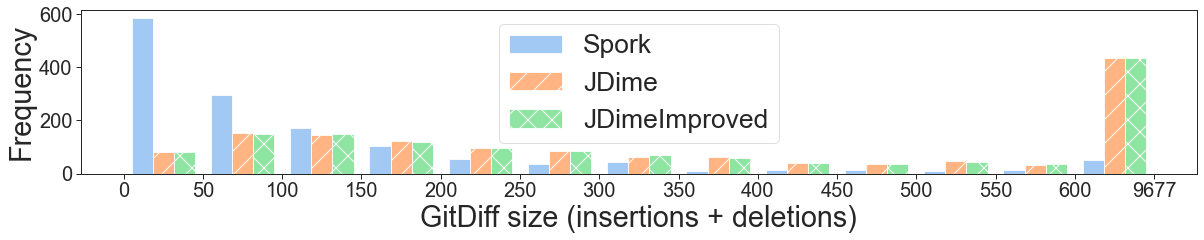

In [9]:
def plot_git_diff_sizes():
    filtered_file_merges = FILE_MERGE_EVALS[
        ~FILE_MERGE_EVALS.merge_dir.isin(FAIL_MERGE_DIRS | CONFLICT_MERGE_DIRS)
    ]
    aligned_file_merges = get_aligned_results(
        merge_id_column="merge_dir",
        tool_column="merge_cmd",
        data_column="line_diff_size",
        frame=filtered_file_merges,
    )
    bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
    plot = histogram(
        spork_values=aligned_file_merges.spork_line_diff_size,
        jdime_values=aligned_file_merges.jdime_line_diff_size,
        automergeptm_values=aligned_file_merges.automergeptm_line_diff_size,
        bins=bins,
        xlabel="GitDiff size (insertions + deletions)",
    )

plot_git_diff_sizes()
    

## Character size

Spork vs JDime
P-value: 1.2889704249830537e-199, RBC: -0.9294328537889565
Spork vs AutoMergePTM
P-value: 2.259337680435125e-205, RBC: -0.9435761761784154


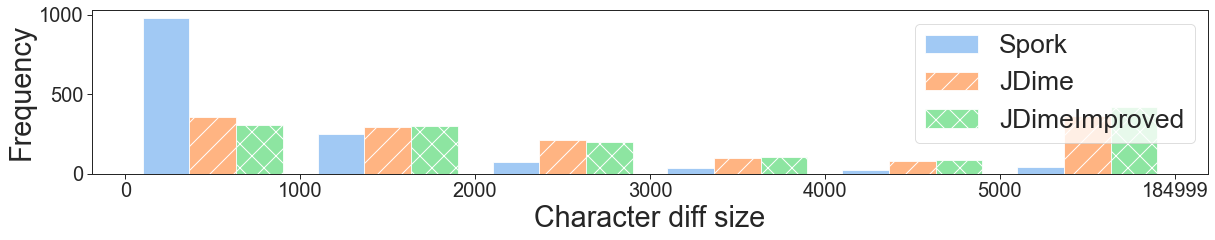

In [5]:
def plot_char_diff_size():
    bins = [0, 1000, 2000, 3000, 4000, 5000, 6000]
    filtered_file_merges = FILE_MERGE_EVALS[
        ~FILE_MERGE_EVALS.merge_dir.isin(FAIL_MERGE_DIRS | CONFLICT_MERGE_DIRS)
    ]
    aligned_file_merges = get_aligned_results(
        merge_id_column="merge_dir",
        tool_column="merge_cmd",
        data_column="char_diff_size",
        frame=filtered_file_merges,
    )
    histogram(
        spork_values=aligned_file_merges.spork_char_diff_size,
        jdime_values=aligned_file_merges.jdime_char_diff_size,
        automergeptm_values=aligned_file_merges.automergeptm_char_diff_size,
        bins=bins,
        xlabel="Character diff size",
    )

plot_char_diff_size()

## Number of conflicts

Spork vs JDime
P-value: 1.9618264385693907e-08, RBC: -0.43596156377517437
Spork vs AutoMergePTM
P-value: 0.6440995432981025, RBC: -0.03560454567624255


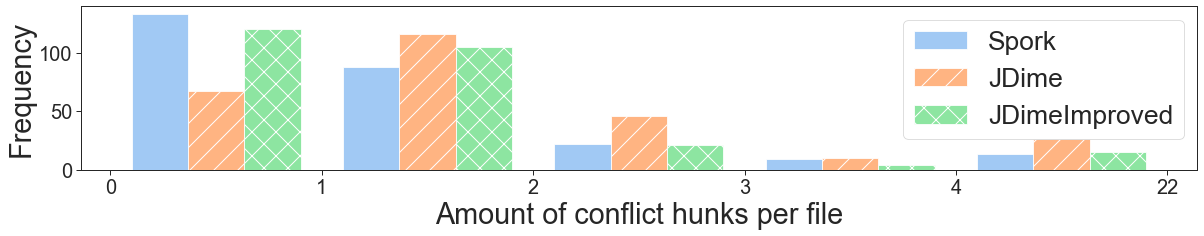

In [6]:
def plot_conflict_hunk_quantities():
    bins = [0, 1, 2, 3, 4, 5]
    non_fail_conflict_dirs = CONFLICT_MERGE_DIRS - FAIL_MERGE_DIRS
    conflicts = FILE_MERGE_EVALS[
        FILE_MERGE_EVALS.merge_dir.isin(non_fail_conflict_dirs)
    ]
    aligned_conflicts = get_aligned_results(
        merge_id_column="merge_dir",
        tool_column="merge_cmd",
        data_column="num_conflicts",
        frame=conflicts,
    )
    histogram(
        spork_values=aligned_conflicts.spork_num_conflicts,
        jdime_values=aligned_conflicts.jdime_num_conflicts,
        automergeptm_values=aligned_conflicts.automergeptm_num_conflicts,
        bins=bins,
        xlabel="Amount of conflict hunks per file",
    )

plot_conflict_hunk_quantities()

## Conflicts size

Spork vs JDime
P-value: 0.011244432485278986, RBC: -0.20813616521771028
Spork vs AutoMergePTM
P-value: 0.8333449205297269, RBC: -0.016330728095433955


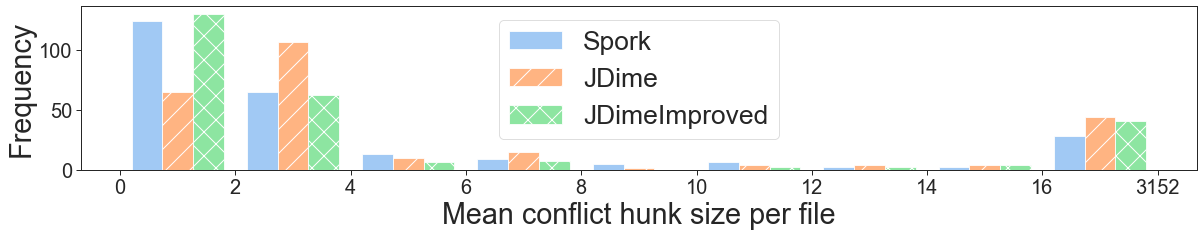

In [7]:
def plot_mean_conflict_sizes():
    bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
    aligned_mean_conflict_sizes = get_aligned_mean_conflict_sizes().query(
        "spork_avg_size > 0 or jdime_avg_size > 0 or automergeptm_avg_size > 0"
    )
    histogram(
        spork_values=aligned_mean_conflict_sizes.spork_avg_size,
        jdime_values=aligned_mean_conflict_sizes.jdime_avg_size,
        automergeptm_values=aligned_mean_conflict_sizes.automergeptm_avg_size,
        bins=bins,
        xlabel="Mean conflict hunk size per file",
    )

plot_mean_conflict_sizes()

## Runtime

Spork vs JDime
P-value: 2.885966059443973e-50, RBC: -0.42158187067622444
Spork vs AutoMergePTM
P-value: 2.973834610102107e-113, RBC: -0.6403999775584452


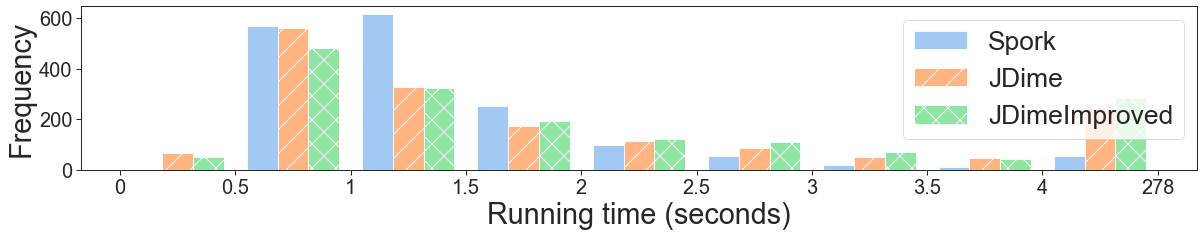

In [8]:
def plot_runtimes():
    bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
    non_fail_merges = FILE_MERGE_EVALS[
        ~FILE_MERGE_EVALS.merge_dir.isin(FAIL_MERGE_DIRS)
    ]
    aligned_file_merges = get_aligned_results(
        merge_id_column="merge_dir",
        tool_column="merge_cmd",
        data_column="runtime",
        frame=non_fail_merges,
    )
    histogram(
        spork_values=aligned_file_merges.spork_runtime,
        jdime_values=aligned_file_merges.jdime_runtime,
        automergeptm_values=aligned_file_merges.automergeptm_runtime,
        bins=bins,
        xlabel="Running time (seconds)",
    )

plot_runtimes()